# No REST for the wicked

* [GraphQL](#GraphQL)
* [RPC](#RPC)
* [gRPC](#gRPC)
* [BFF](#BFF)


__Goals__:
* рассмотреть альтернативные REST подходы создания API;
* cравнить подходы между собой и определиться с границами применимости.

## GraphQL

это не протокол и не архитектура, это язык запросов

Причины появления:
- проблемы с N+1  у REST (например сначала получаем список пользователей, а потом список покупок по каждому)
- избыточность или недостаток данных в ответах REST

Основные особенности:
- единая точка входа
- POST (т.е. нет кэширования)
- Типизация схемы
- Потоковая передача данных (т.е. не stateless)
- Декларативный язык запросов
- Клиент определяет, что вернуть
- Неочевидная сложность запросов 

Schema example:

<div>
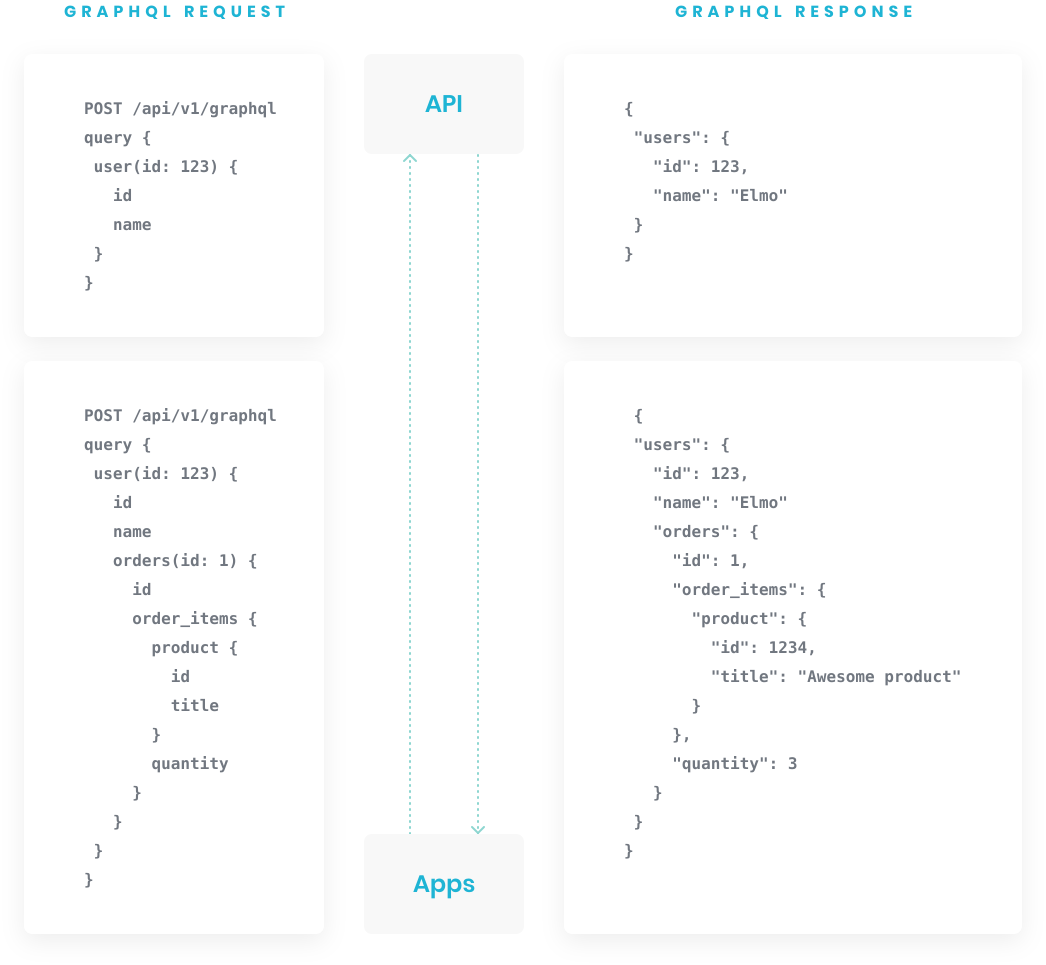
</div>

FastAPI GraphQL example:

In [5]:
# %load /src/graphql/models.py
from sqlalchemy import Column, Integer, String, ForeignKey
from sqlalchemy.ext.declarative import declarative_base

Base = declarative_base()

class College(Base):
    __tablename__ = "colleges"
    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)
    location = Column(String)

class Student(Base):
    __tablename__ = "students"
    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)
    age = Column(Integer)
    college_id = Column(Integer, ForeignKey("colleges.id"))

In [6]:
# %load /src/graphql/database.py
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from models import Base


DATABASE_URI = "sqlite:///./students.db"
engine = create_engine(DATABASE_URI)
Base.metadata.create_all(bind=engine)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

def get_db():
    db = SessionLocal()
    try:
        return db
    finally:
       db.close()

In [7]:
# %load /src/graphql/schema.py
import asyncio
from typing import List, AsyncGenerator
import strawberry
from strawberry import Schema

from models import College, Student
from database import get_db


@strawberry.type
class CollegeType:
    id: int
    name: str
    location: str

@strawberry.type
class StudentType:
    id: int
    name: str
    age: int
    college_id: int


@strawberry.type
class Query:
    @strawberry.field
    async def colleges(self) -> List[CollegeType]:
            db=get_db()
            colleges = db.query(College).all()
            return [CollegeType(id=college.id, name=college.name, location=college.location) for college in colleges]

    @strawberry.field
    async def students(self) -> List[StudentType]:
            db=get_db()
            students = db.query(Student).all()
            return [StudentType(id=student.id, name=student.name, age=student.age, college_id=student.college_id) for student in students]


@strawberry.type
class Mutation:
    @strawberry.mutation
    async def create_college(self, name: str, location: str) -> CollegeType:
            db=get_db() 
            college = College(name=name, location=location)
            db.add(college)
            db.commit()
            db.refresh(college)
            return CollegeType(id=college.id, name=college.name, location=college.location)

    @strawberry.mutation
    async def create_student(self, name: str, age: int, college_id: int) -> StudentType:
            db=get_db()
            college = db.query(College).filter(College.id == college_id).first()
            if not college:
                raise ValueError("College not found")
            student = Student(name=name, age=age, college_id=college_id)
            db.add(student)
            db.commit()
            db.refresh(student)
            return StudentType(id=student.id, name=student.name, age=student.age, college_id=student.college_id)


async def student_stream(college_id: int) -> AsyncGenerator[StudentType, None]:
    while True:
        await asyncio.sleep(5)  # Simulate real-time updates
        db=get_db() 
        student = db.query(Student).filter(Student.college_id == college_id).order_by(Student.id.desc()).first()
        if student:
            yield StudentType(id=student.id, name=student.name, age=student.age, college_id=student.college_id)


@strawberry.type
class Subscription:
    @strawberry.subscription
    async def student_added(self, college_id: int) -> StudentType:
        async for student in student_stream(college_id):
            yield student

schema = Schema(query=Query, mutation=Mutation, subscription=Subscription)

In [8]:
# %load /src/graphql/main.py
from fastapi import FastAPI
from strawberry.asgi import GraphQL

from schema import schema

app = FastAPI()

@app.get("/")
async def index():
    return {"message": "Welcome to the Student API"}

app.add_route("/graphql", GraphQL(schema))


Executing GraphQL queries using Python requests library

In [ ]:
%%bash
cd /src/graphql
uvicorn main:app --host=0.0.0.0 --reload

Go to http://127.0.0.1:8889/graphql and try quries:

### Problems

__Authorisation__

If you expose a fully self documenting query API to all clients, you better be sure that every field is authorised against the current user appropriately to the context in which that field is being fetched. Compare this to the REST world where generally speaking you would authorise every endpoint, a far smaller task.

__Rate limiting__

Even in a completely empty schema, the types exposed for introspection are cyclical, so its possible to craft a valid query that returns MBs of JSON:

Or:

__Query parsing__

This is a syntactically valid query, but invalid for our schema. A spec compliant server will parse this and start building an errors response containing thousands of errors which we found consumed 2,000x more memory than the query string itself. 

__N+1 problem__

-  if a field resolver hits an external data source such as a DB or HTTP API, and it is nested in a list containing N items, it will do those calls N times.
-  integrating with your library’s authorisation framework, you’ve now got a whole new category of N+1 problems to deal with

In [ ]:
class UserType < GraphQL::BaseObject
  field :handle, String
  field :birthday, authorize_with: :view_pii
end

class UserPolicy < ApplicationPolicy
  def view_pii?
    # Oh no, I hit the DB to fetch the user's friends
    user.friends_with?(record)
  end
end

## RPC

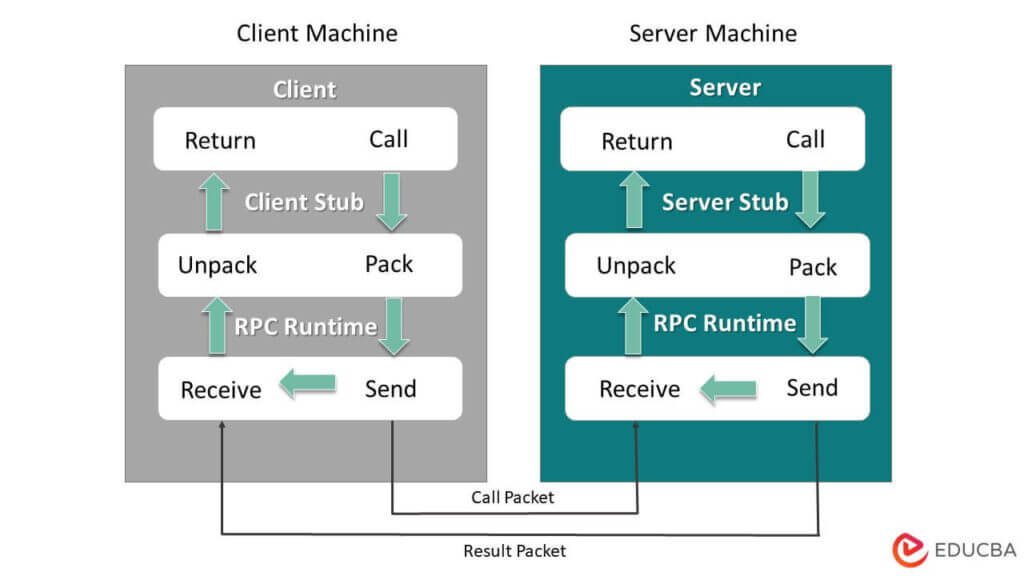

## gRPC

это абстракция над HTTP/2, но если точнее:

gRPC is a modern open-source high-performance RPC framework that can run in any environment. It can efficiently connect services in and across data centers with pluggable support for load balancing, tracing, health checking and authentication

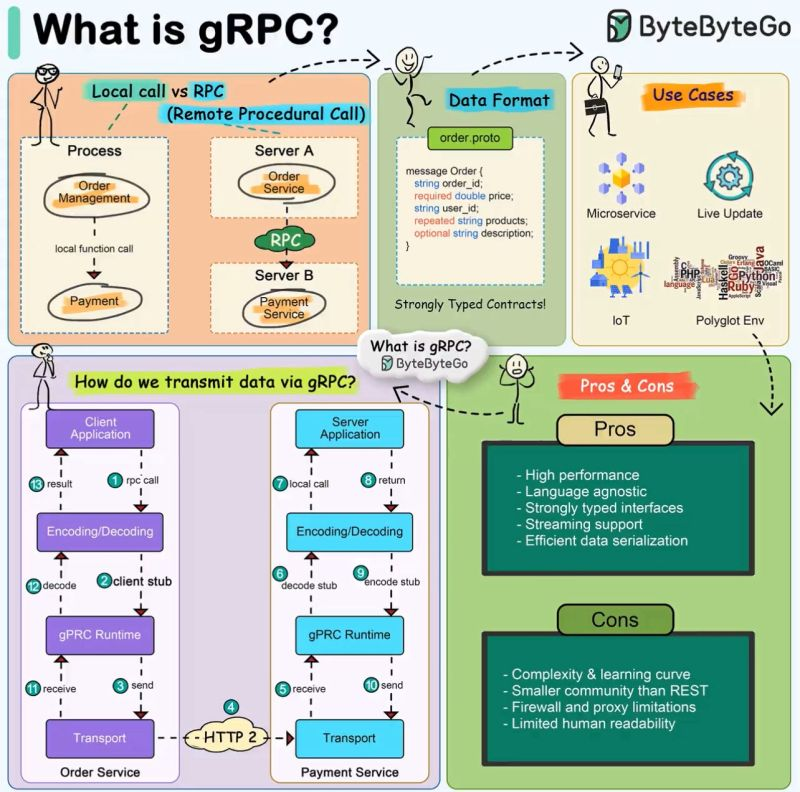

Все поюсы этой версии HTTP применимы и к gRPC:
- бинарный формат сообщений
- мультиплексирование в едином TCP канале
- быстрая и безошибочная передача данных
- push ресурсов
- сжатие заголовков

Абстракция над HTTP/2 позволила создать функционал без привязки к транспорту:
- Одиночные и потоковые вызовы
- Метаданные
- Отмена запроса и таймауты
- IDL для описания сервисов с помощью .proto файлов
- Кодогенерация серверов и клиентов
- Плагины для обратного прокси-сервера REST HTTP/1.1

#### HTTP/2

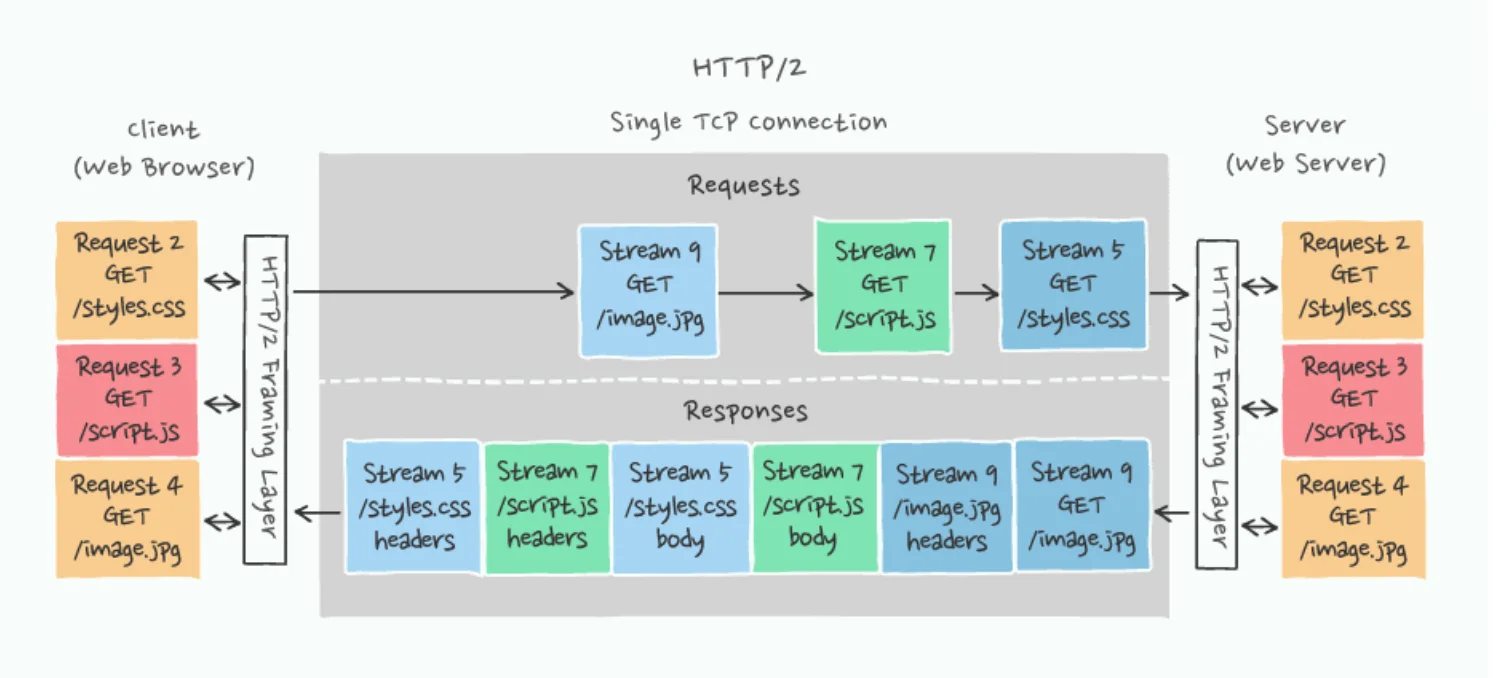

<div>
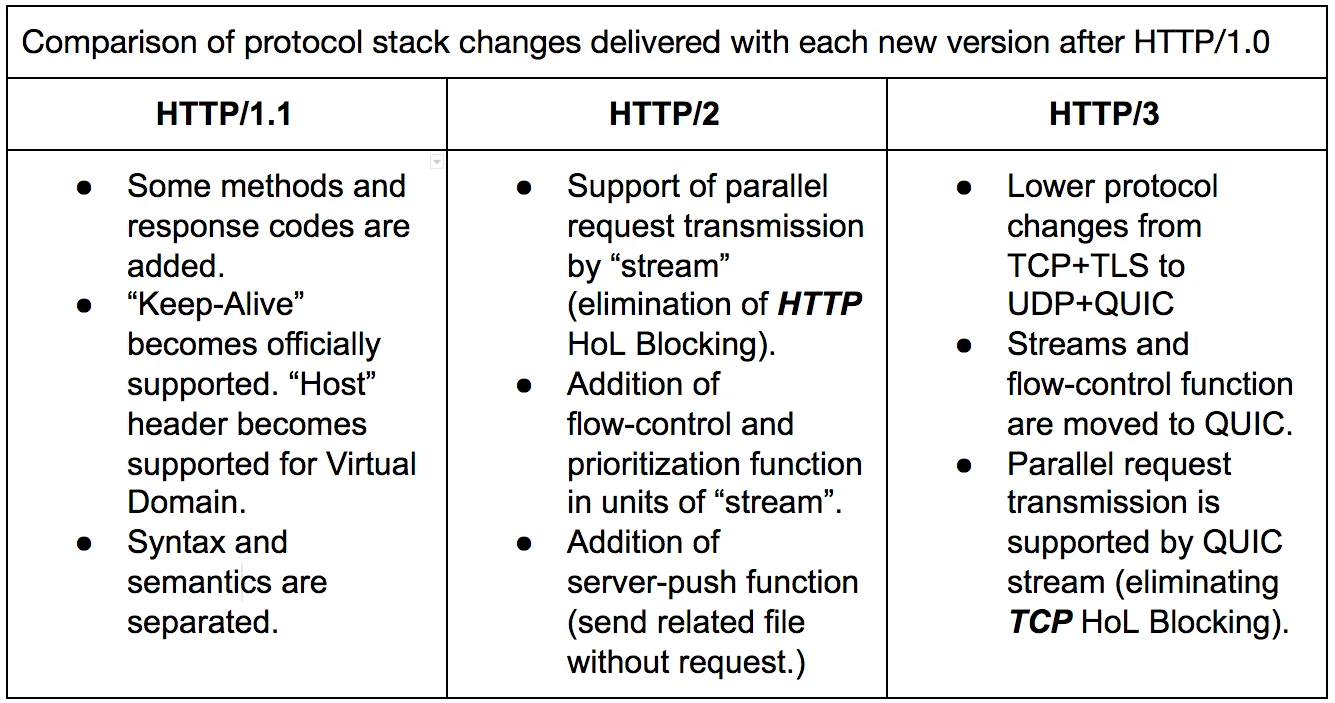
</div>

<div>
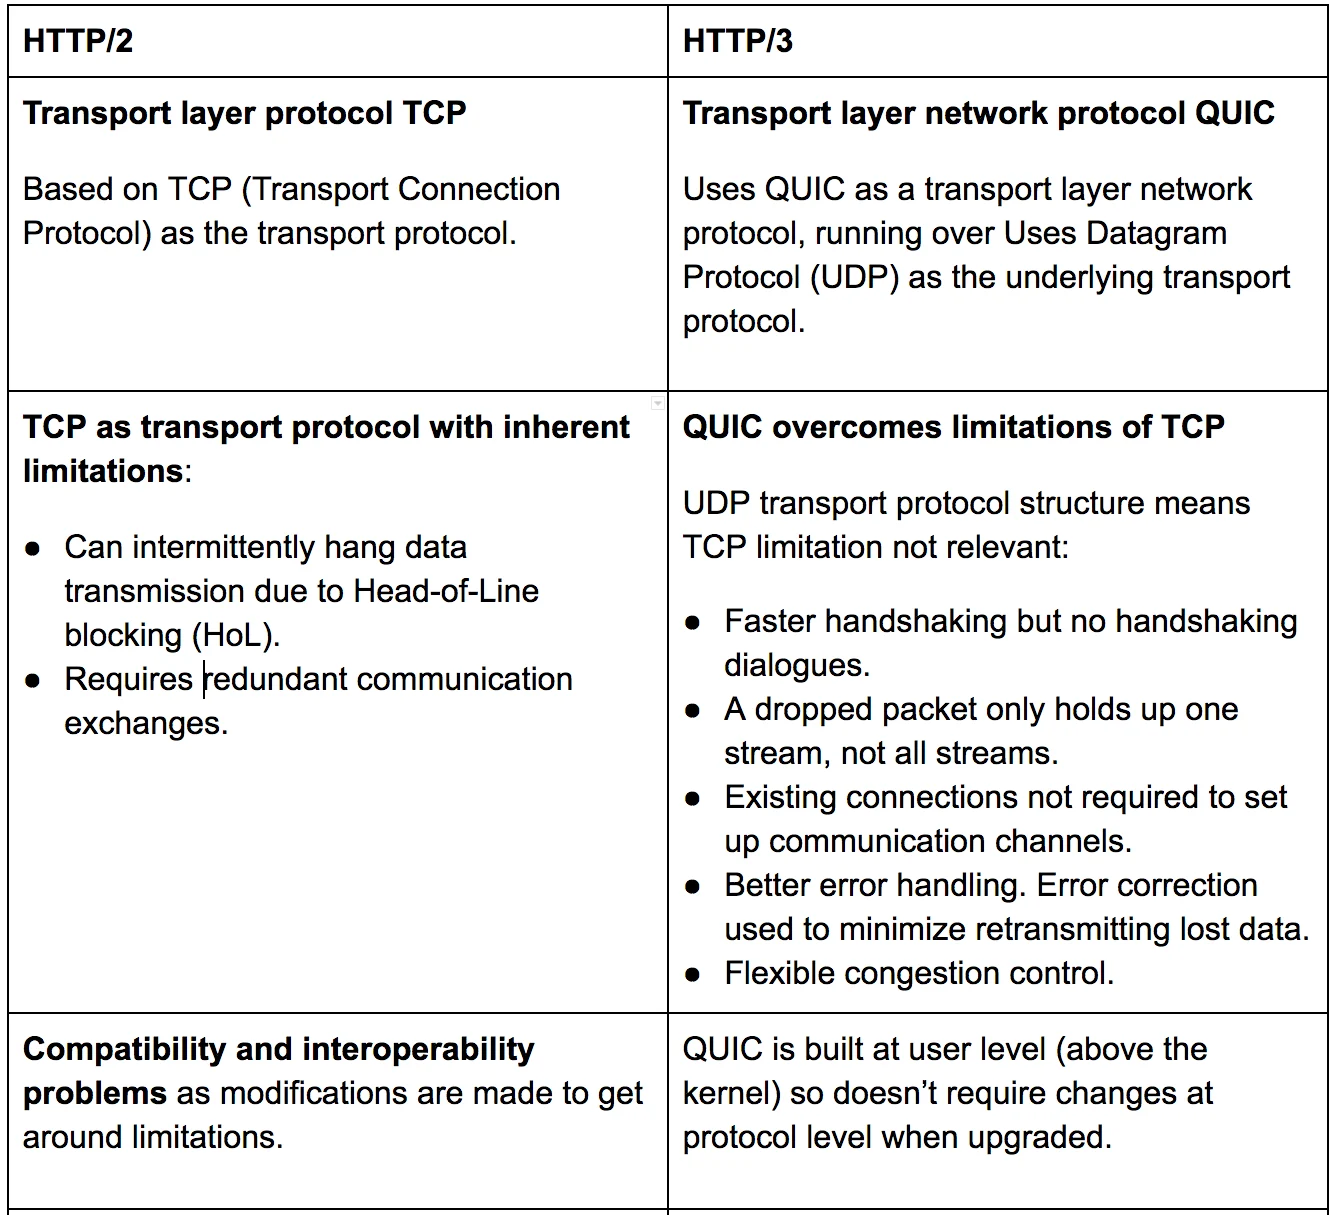
</div>

<div>
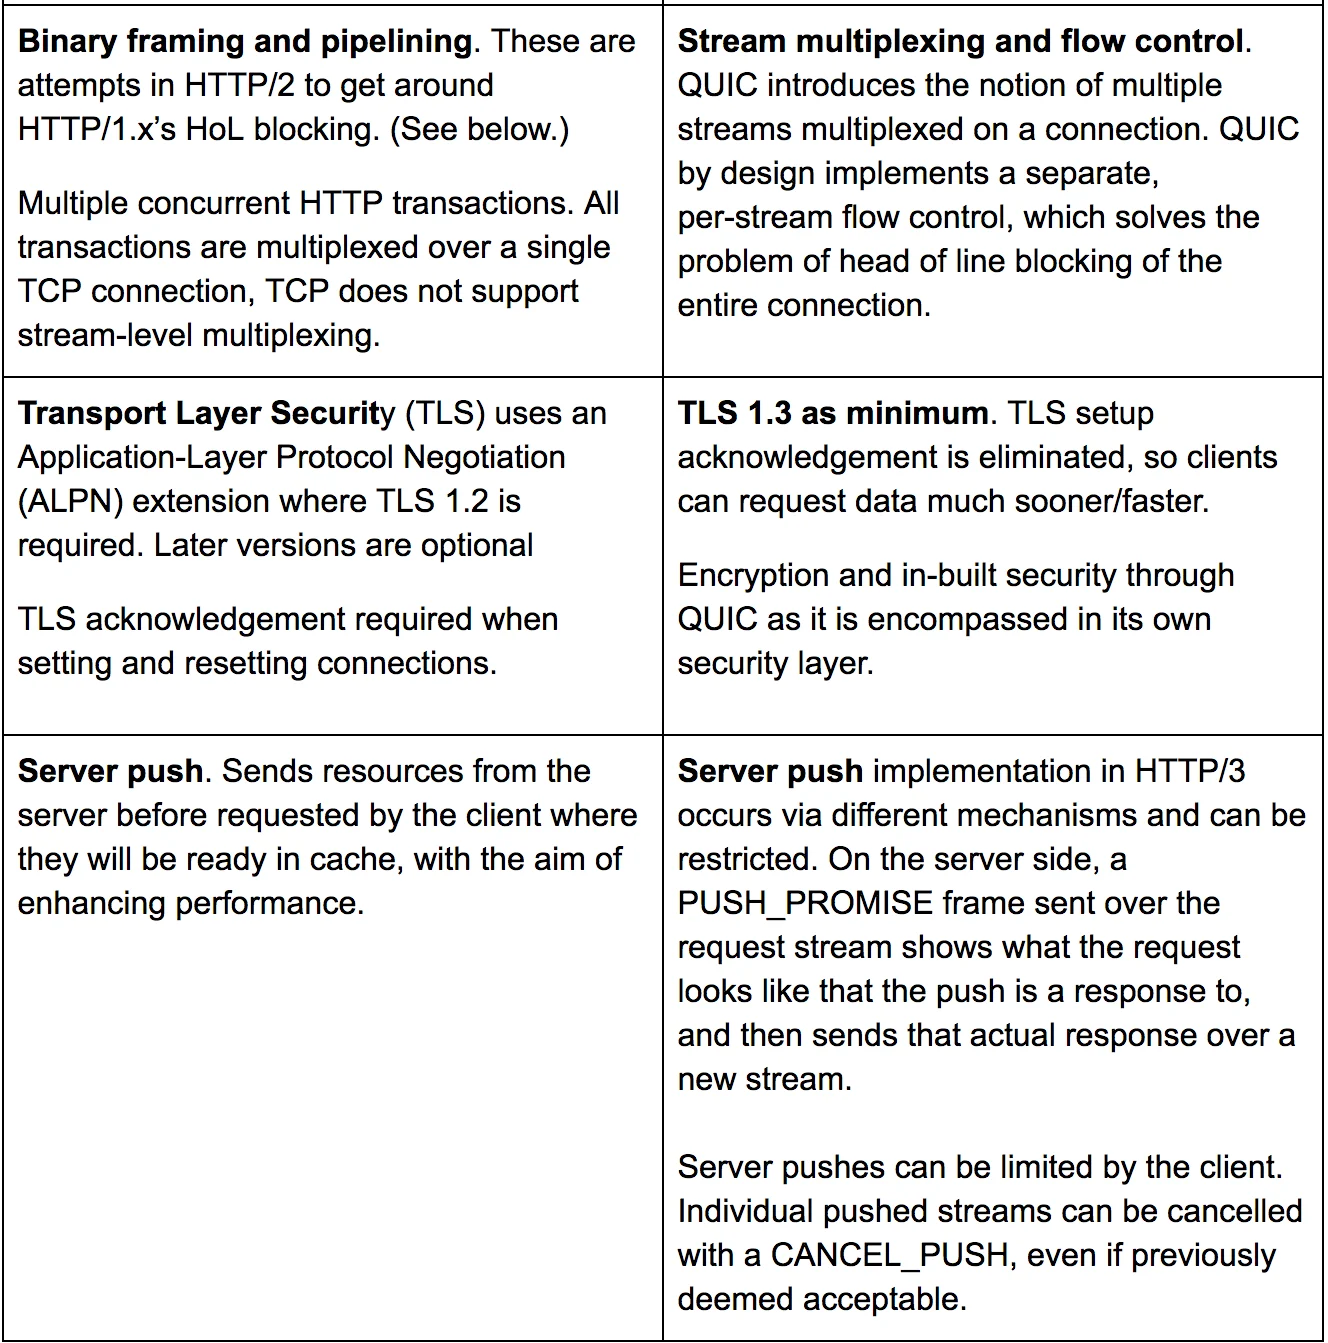
</div>

#### protobuf

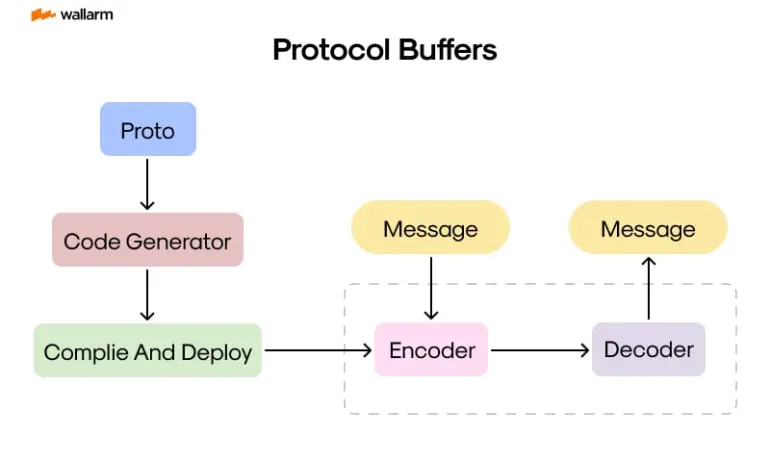

Define proto:

In [20]:
# %load /src/grpc/protobuf/person.proto
syntax = "proto3";

import "generated/person_info.proto";

package persons;

message Person {
    PersonInfo info = 1; // characteristics of the person
    repeated Friend friends = 2; // friends of the person
}

message Friend {
    float friendship_duration = 1; // duration of friendship in days
    repeated string shared_hobbies = 2; // shared interests
    Person person = 3; // identity of the friend
}

In [21]:
# %load /src/grpc/protobuf/person_info.proto
syntax = "proto3";

package persons;

enum Sex {
    M = 0; // male 
    F = 1; // female
    O = 2; // other
}

message PersonInfo {
    int32 age = 1; // age in years
    Sex sex = 2; 
    int32 height = 3; // height in cm
}

Compile:

In [2]:
%%bash
mkdir -p /src/grpc/protobuf/generated
protoc /src/grpc/protobuf/person_info.proto --python_out /src/grpc/protobuf/ --proto_path generated=/src/grpc/protobuf/
protoc /src/grpc/protobuf/person.proto --python_out /src/grpc/protobuf/ --proto_path generated=/src/grpc/protobuf/
ls /src/grpc/protobuf/generated/

__pycache__
person_info_pb2.py
person_pb2.py


In [23]:
# %load /src/grpc/protobuf/generated/person_pb2.py
# Generated by the protocol buffer compiler.  DO NOT EDIT!
# source: generated/person.proto
"""Generated protocol buffer code."""
from google.protobuf.internal import builder as _builder
from google.protobuf import descriptor as _descriptor
from google.protobuf import descriptor_pool as _descriptor_pool
from google.protobuf import symbol_database as _symbol_database
# @@protoc_insertion_point(imports)

_sym_db = _symbol_database.Default()


from generated import person_info_pb2 as generated_dot_person__info__pb2


DESCRIPTOR = _descriptor_pool.Default().AddSerializedFile(b'\n\x16generated/person.proto\x12\x07persons\x1a\x1bgenerated/person_info.proto\"M\n\x06Person\x12!\n\x04info\x18\x01 \x01(\x0b\x32\x13.persons.PersonInfo\x12 \n\x07\x66riends\x18\x02 \x03(\x0b\x32\x0f.persons.Friend\"^\n\x06\x46riend\x12\x1b\n\x13\x66riendship_duration\x18\x01 \x01(\x02\x12\x16\n\x0eshared_hobbies\x18\x02 \x03(\t\x12\x1f\n\x06person\x18\x03 \x01(\x0b\x32\x0f.persons.Personb\x06proto3')

_builder.BuildMessageAndEnumDescriptors(DESCRIPTOR, globals())
_builder.BuildTopDescriptorsAndMessages(DESCRIPTOR, 'generated.person_pb2', globals())
if _descriptor._USE_C_DESCRIPTORS == False:

  DESCRIPTOR._options = None
  _PERSON._serialized_start=64
  _PERSON._serialized_end=141
  _FRIEND._serialized_start=143
  _FRIEND._serialized_end=237
# @@protoc_insertion_point(module_scope)


Serialize:

In [24]:
# %load /src/grpc/protobuf/test_proto.py
# fill protobuf objects
import generated.person_pb2 as person_pb2
import generated.person_info_pb2 as person_info_pb2
############
# define friend for person of interest
#############
friend_info = person_info_pb2.PersonInfo()
friend_info.age = 40
friend_info.sex = person_info_pb2.Sex.M
friend_info.height = 165
friend_person = person_pb2.Person()
friend_person.info.CopyFrom(friend_info)
friend_person.friends.extend([])  # no friends :-(
#######
# define friendship characteristics
########
friendship = person_pb2.Friend()
friendship.friendship_duration = 365.1
friendship.shared_hobbies.extend(["books", "daydreaming", "unicorns"])
friendship.person.CopyFrom(friend_person)
#######
# assign the friend to the friend of interest
#########
person_info = person_info_pb2.PersonInfo()
person_info.age = 30
person_info.sex = person_info_pb2.Sex.M
person_info.height = 184
person = person_pb2.Person()
person.info.CopyFrom(person_info)
person.friends.extend([friendship])  # person with a single friend

# serialize proto object
print(str(person))
print(person.SerializeToString())

In [3]:
!python /src/grpc/protobuf/test_proto.py

info {
  age: 30
  height: 184
}
friends {
  friendship_duration: 365.1
  shared_hobbies: "books"
  shared_hobbies: "daydreaming"
  shared_hobbies: "unicorns"
  person {
    info {
      age: 40
      height: 165
    }
  }
}

b'\n\x05\x08\x1e\x18\xb8\x01\x12,\r\xcd\x8c\xb6C\x12\x05books\x12\x0bdaydreaming\x12\x08unicorns\x1a\x07\n\x05\x08(\x18\xa5\x01'


#### gRPC types

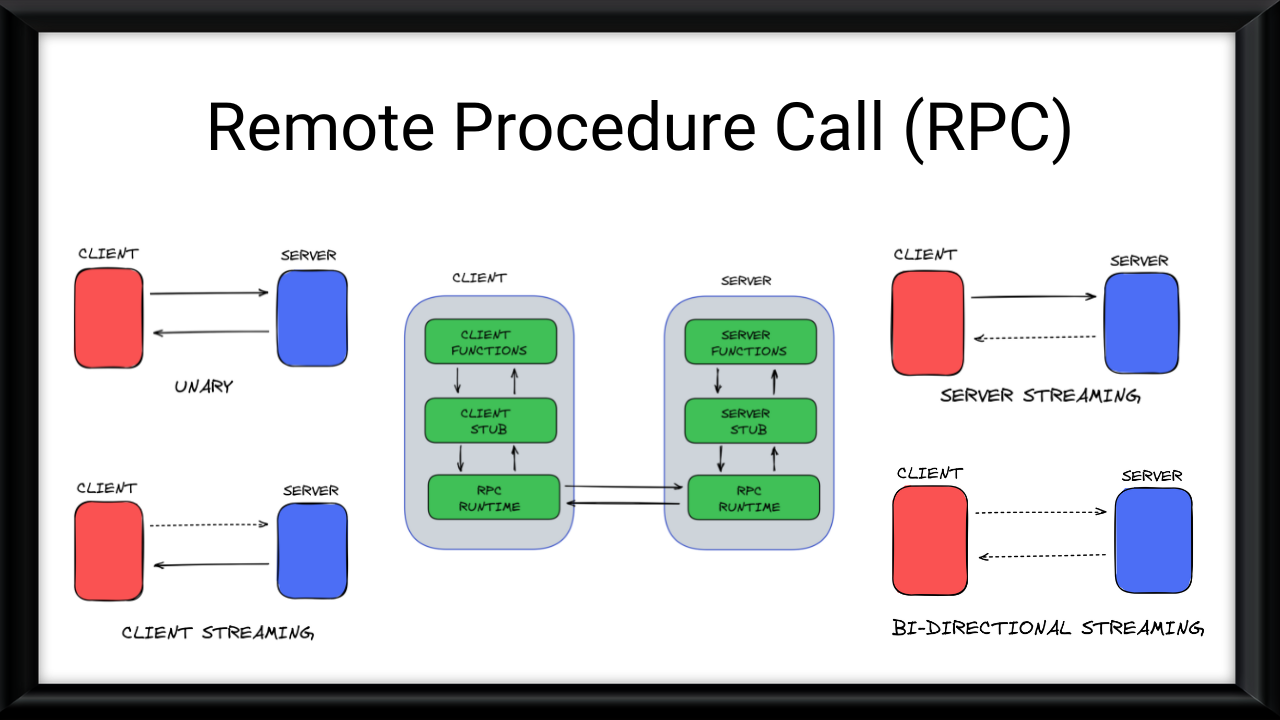

#### Example

In [27]:
# %load /src/grpc/calculator.proto
syntax = "proto3";

package calculator;

service Calculator {
  rpc Add (AddRequest) returns (AddResponse);
}

message AddRequest {
  int32 num1 = 1;
  int32 num2 = 2;
}

message AddResponse {
  int32 result = 1;
}

In [4]:
%%bash
python -m grpc_tools.protoc -I/src/grpc/ --python_out=/src/grpc/ --grpc_python_out=/src/grpc/ /src/grpc/calculator.proto
ls /src/grpc/*pb2*

/src/grpc/calculator_pb2.py
/src/grpc/calculator_pb2_grpc.py


In [34]:
# %load /src/grpc/server.py
import grpc
from concurrent import futures
import calculator_pb2
import calculator_pb2_grpc

class CalculatorServicer(calculator_pb2_grpc.CalculatorServicer):
    def Add(self, request, context):
        result = request.num1 + request.num2
        return calculator_pb2.AddResponse(result=result)

def serve():
    server = grpc.server(futures.ThreadPoolExecutor(max_workers=10))
    calculator_pb2_grpc.add_CalculatorServicer_to_server(CalculatorServicer(), server)
    server.add_insecure_port('[::]:50051')
    server.start()
    server.wait_for_termination()

if __name__ == '__main__':
    serve()

In [35]:
# %load /src/grpc/client.py
import grpc
import calculator_pb2
import calculator_pb2_grpc

def run(num1, num2):
    with grpc.insecure_channel('localhost:50051') as channel:
        stub = calculator_pb2_grpc.CalculatorStub(channel)
        response = stub.Add(calculator_pb2.AddRequest(num1=num1, num2=num2))
    print(f"Result: {response.result}")

if __name__ == '__main__':
    # Get user Input 
    num1 = int(input("Please input num1: "))
    num2 = int(input("Please input num2: "))
    run(num1, num2)

In [42]:
! python /src/grpc/server.py

^C
Traceback (most recent call last):
  File "/src/grpc/server.py", line 19, in <module>
    serve()
  File "/src/grpc/server.py", line 16, in serve
    server.wait_for_termination()
  File "/usr/local/lib/python3.12/site-packages/grpc/_server.py", line 1494, in wait_for_termination
    return _common.wait(
           ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/grpc/_common.py", line 156, in wait
    _wait_once(wait_fn, MAXIMUM_WAIT_TIMEOUT, spin_cb)
  File "/usr/local/lib/python3.12/site-packages/grpc/_common.py", line 116, in _wait_once
    wait_fn(timeout=timeout)
  File "/usr/local/lib/python3.12/threading.py", line 655, in wait
    signaled = self._cond.wait(timeout)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/threading.py", line 359, in wait
    gotit = waiter.acquire(True, timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


In [41]:
! python /src/grpc/client.py

Please input num1: ^C
Traceback (most recent call last):
  File "/src/grpc/client.py", line 13, in <module>
    num1 = int(input("Please input num1: "))
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


#### Gateway

<div>
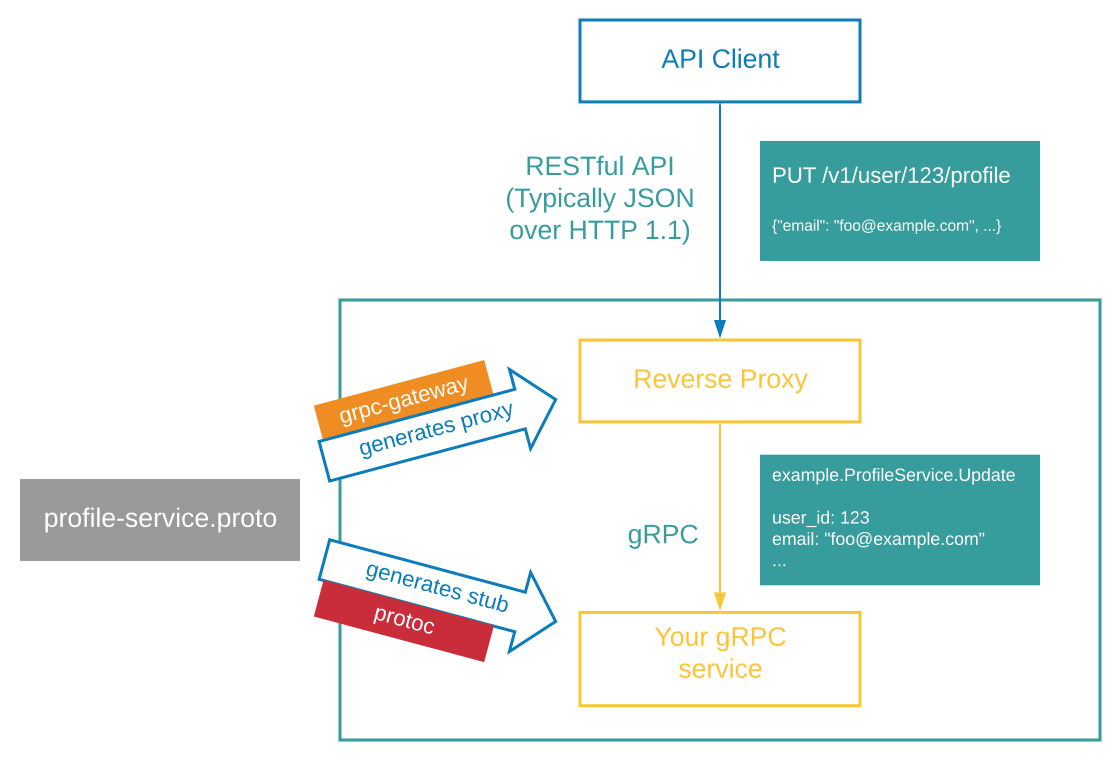
</div>

## BFF

Microservices era problem:

<div>
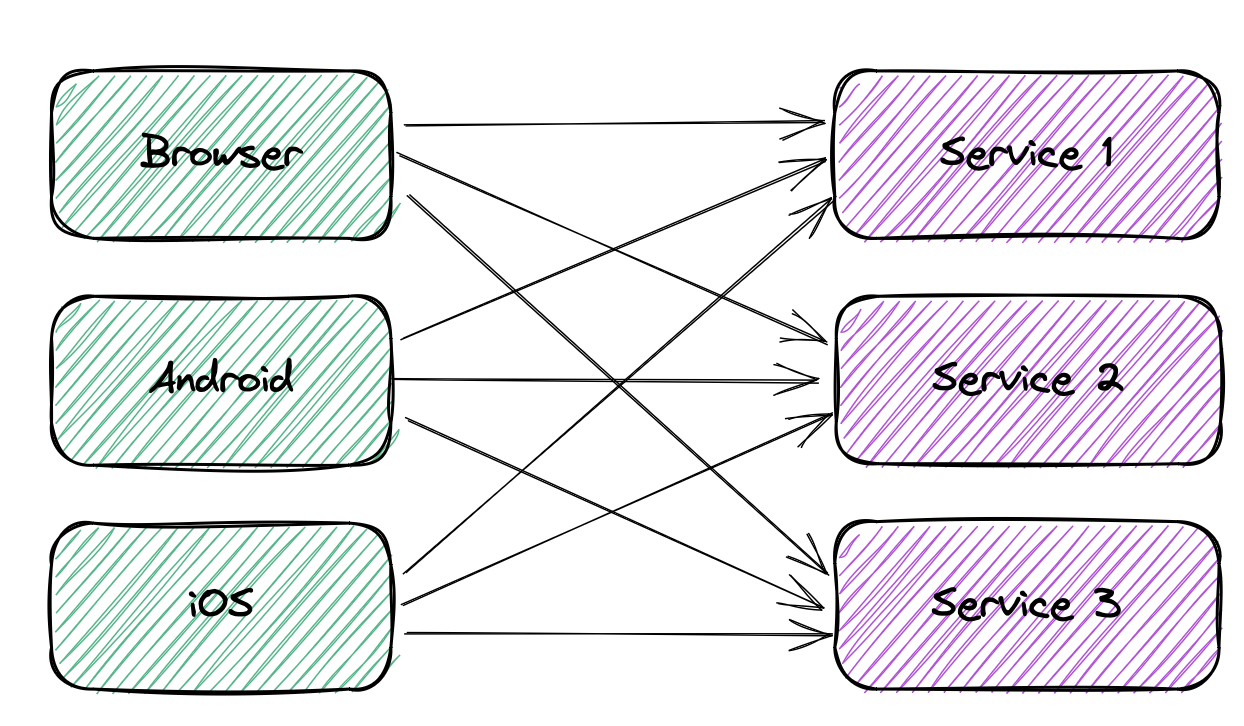
</div>

API Gateway
- bloated logic
- dedicated team

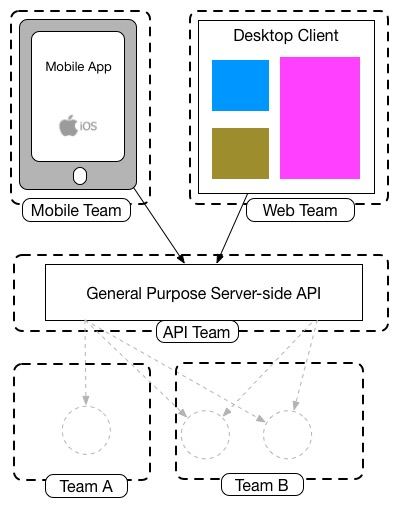

Microservice needs to return the exact data necessary, depending on the client. It introduces strong coupling between a microservice and its clients. You want to remove this coupling. To achieve it, the Backend For Front-end approach extracts the cleaning logic away from each service into a dedicated component, also tasked with aggregating data

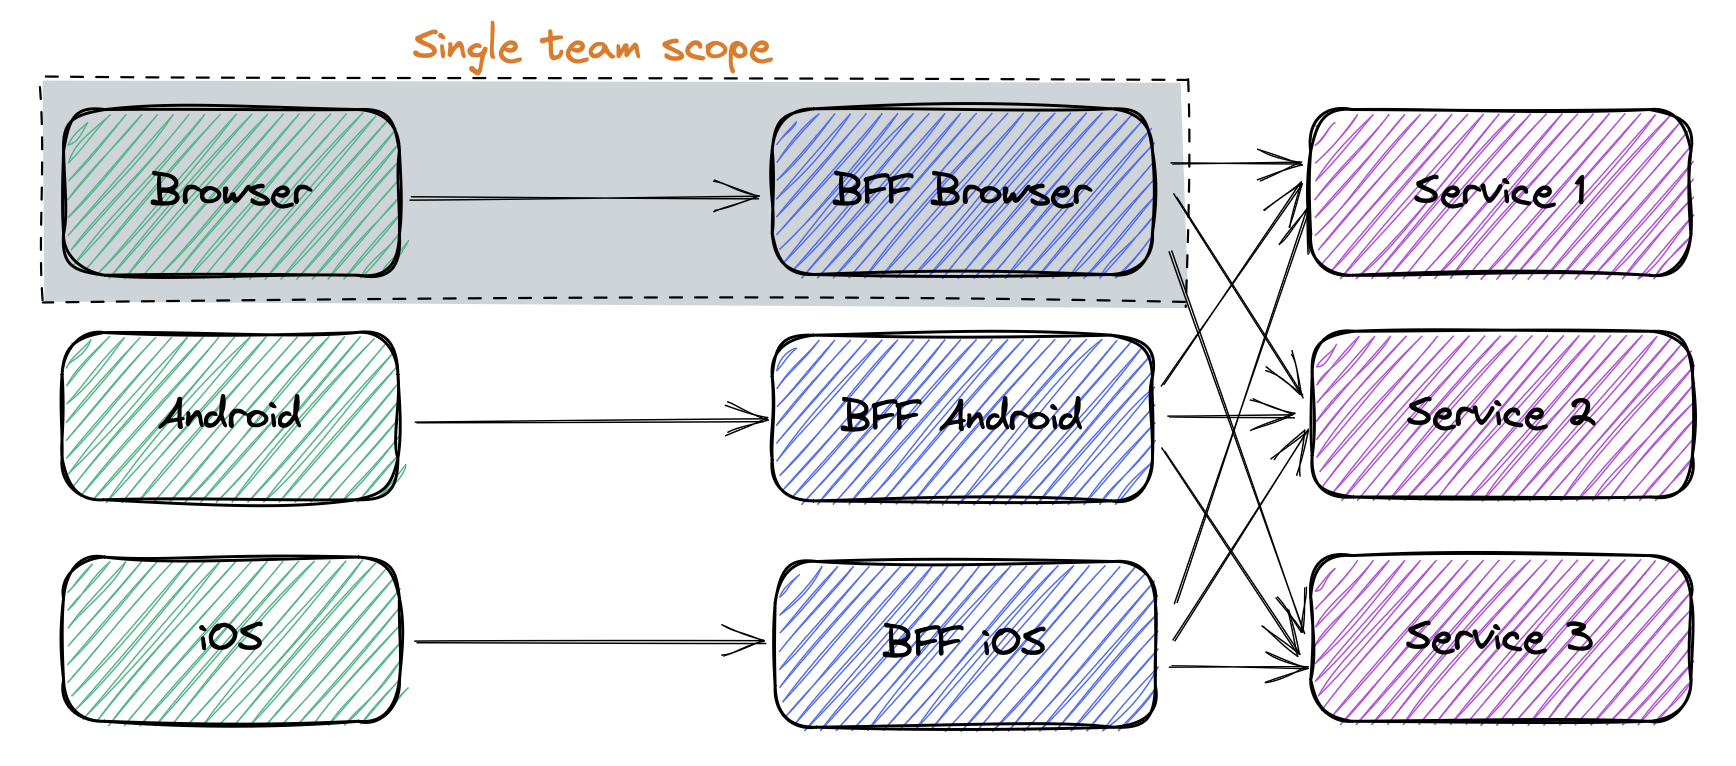

### References

* https://protobuf.dev/
* https://habr.com/ru/companies/yandex/articles/484068/
* https://graphql.org/learn/
* https://stackoverflow.blog/2022/11/28/when-to-use-grpc-vs-graphql/
* https://www.danhacks.com/software/grpc-rest-graphql.html
* https://realpython.com/python-microservices-grpc/
* https://mobilelive.medium.com/graphql-in-python-a-comprehensive-guide-to-building-apis-59cb0d638c03
* https://bessey.dev/blog/2024/05/24/why-im-over-graphql/
* https://blog.frankel.ch/backend-for-frontend/
* https://samnewman.io/patterns/architectural/bff/